## Analysis of parking data

In [150]:
# importing libraries and stuff 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import kruskal

The first step was to scrape the data about the weather in Milan from 2019 to 2022 using the library *beautifulsup*. Unfortunately I lost the code (but I still have the datasets).
After this I load both the parking data and those about the weather.

In [151]:
# Load parking data 
data = pd.read_csv("milano_parking.csv")
data['date'] = pd.to_datetime(data['date'])
data.drop('Unnamed: 0', axis = 1, inplace=True)

In [152]:
# auxiliary function to retrieve the data given the month and the year

def get_data(month, year):
    temp = pd.read_csv(f"Meteo_data/Milano-{year}-{month}.csv")
    df = pd.DataFrame()
    
    # info I'm interested in
    date = []
    tavg = []
    tmin = []
    tmax = []
    humidity = []
    wind_avg = []
    rain = []
    other = []
    for _, row in temp.iterrows():
        dt = row.values[0].split(';')
        date.append(dt[1])
        tavg.append(dt[2].strip('"'))
        tmin.append(dt[3].strip('"'))
        tmax.append(dt[4].strip('"'))
        humidity.append(dt[6].strip('"'))
        wind_avg.append(dt[8].strip('"'))
        rain.append(dt[13].strip('"'))
        other.append(dt[14].strip('"'))

    
    df['date'] = date
    df['tavg'] = tavg
    df['tmin'] = tmin
    df['tmax'] = tmax
    df['humidity'] = humidity
    df['wind_avg'] = wind_avg
    df['rain'] = rain
    df['other'] = other
    return df

In [153]:
# poor man's data loader

months = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']
years = ['2019', '2020', '2021', '2022']
monthly_dataframes = []

for year in years:
    for month in months:
        temp = get_data(month, year)

        df = pd.DataFrame(temp)

        monthly_dataframes.append(df)

meteo_data = pd.concat(monthly_dataframes, axis=0)
meteo_data.reset_index(inplace=True)

# convert the date colum to datetime data type
meteo_data['date'] = pd.to_datetime(meteo_data['date'], format='%d/%m/%Y')

In [154]:
new = pd.concat([data, meteo_data], axis = 1).loc[:1460]
new.columns = ['SB_cash', 'SL_cash', 'SB_num', 'SL_num', 'date', 'index', 'date_2','tavg', 'tmin', 
               'tmax', 'humidity', 'wind_avg', 'rain', 'other']
new.drop(['index', 'date_2'], axis = 1, inplace=True)
data = new.copy()

Stating from the original fields create:
- from *date* the month and day_of_week columns
- from *other* the rain feature (1 if it has rained that day)
- from the SB (in italian "sosta breve" meaning short stay) and SL (in italian "sosta lunga" meaning long stay) two field with the total number of accesses and total revenues for the day. This is done beacuse in my analysis I care only about the aggregated number of accesses and revenues rather than the split into short and long stay.


In [155]:
data['month'] = data['date'].apply(lambda x: x.month)
data['day_of_week'] = data['date'].apply(lambda x: x.day_name())
data['rain'] = data['other'].apply(lambda x: int('pioggia' in str(x)))

data['tot_num'] = data['SB_num']+data['SL_num']
data['tot_cash'] = data['SB_cash']+data['SL_cash']

For an initial analysis I discard data before 2020 both because there are a lot of missing values and to exclude the (obvious) drop in revenues during the COVID-19 pandemic

In [156]:
#consider only after 2020
data = data[data['date']>'01-01-2021'].reset_index()

data.to_csv("data_with_meteo.csv")

## Data Analysis

Round the values of two outliers, these had very extreme and unexplicable values. Indeed they did not seem to be linked with any particular date or connected to any events happening nearby. Moreover the days surrounding them did not show abnormal values, this means that the extreme observations were just isolated on two random days.\
To clarify any doubt I tried asking the owners of the car parking and they themselves did not seem to be able to explain the cause.\
My conclusion is that most likely these come from an error in the dataset creation.

In [157]:
data = pd.read_csv(r"data_with_meteo.csv")


data.loc[516, 'SL_num'] = np.round(data['SL_num'].quantile(0.99))
data.loc[578, 'SL_num'] = np.round(data['SL_num'].quantile(0.99))
data.loc[612, 'SL_num'] = np.round(data['SL_num'].quantile(0.99))

data['SL_num'] = data['SL_num'].fillna(data['SL_num'].median())
data['SB_num'] = data['SB_num'].fillna(data['SB_num'].median())

data['SL_cash'] = data['SL_cash'].fillna(data['SL_cash'].median())
data['SB_cash'] = data['SB_cash'].fillna(data['SB_cash'].median())

data['tot_num'] = data['tot_num'].fillna(data['tot_num'].median())
data['tot_cash'] = data['tot_cash'].fillna(data['tot_cash'].median())

data['date'] = pd.to_datetime(data['date'])
data.head()

,Unnamed: 0,index,SB_cash,SL_cash,SB_num,SL_num,date,tavg,tmin,tmax,humidity,wind_avg,rain,other,month,day_of_week,tot_num,tot_cash
0,0,728,84.0,340.0,18.0,6.0,2021-01-02,10.0,6.0,13.0,68.0,17.0,1,pioggia,1,Saturday,24.0,424.0
1,1,729,117.0,686.0,27.0,15.0,2021-01-03,6.0,5.0,9.0,67.0,23.0,0,NaN,1,Sunday,42.0,803.0
2,2,730,6.0,1800.0,2.0,41.0,2021-01-04,8.0,5.0,12.0,70.0,16.0,1,pioggia,1,Monday,163.0,2344.0
3,3,731,3.0,1800.0,1.0,41.0,2021-01-05,4.0,3.0,7.0,80.0,25.0,1,pioggia,1,Tuesday,163.0,2344.0
4,4,732,75.0,327.0,20.0,5.0,2021-01-06,4.0,3.0,5.0,83.0,31.0,1,pioggia neve,1,Wednesday,25.0,402.0


### Plots

It is immediate from these simple plots that there is a hole in the dataset for the total number of accesses from January 2022 to march 2022 (approximately). It means that in the original data there was a series of NaN values. Since the data for the revenues do not show this problem a possible explanation is just low data quality. \
In any case this is something that needs to be taken into consideration for the remaining part of the analysis

Another key insight that we can gather from looking at the series is that the number of people coming into the parking spot for a "short stop" is higher but the revenues are lower because people staying longer pay more

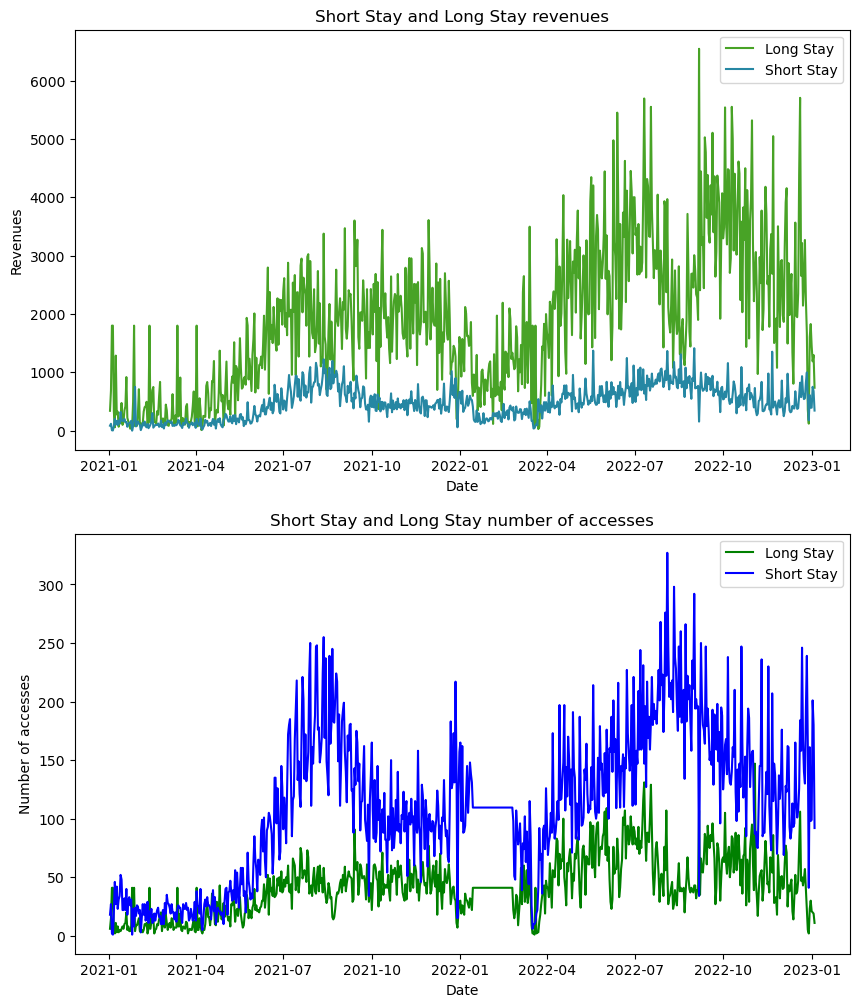

In [158]:
temp = data.copy()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(temp['date'], temp['SL_cash'], color = '#48a326')
axes[0].plot(temp['date'], temp['SB_cash'], color = '#2687a3')
axes[0].set_title('Short Stay and Long Stay revenues')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenues')
axes[0].legend(['Long Stay', 'Short Stay'])

axes[1].plot(temp['date'], temp['SL_num'], color = 'green')
axes[1].plot(temp['date'], temp['SB_num'], color = 'blue') #hole in the series for tot_num
axes[1].set_title('Short Stay and Long Stay number of accesses')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of accesses')
axes[1].legend(['Long Stay', 'Short Stay'])
plt.show()

By looking at the aggregated data it is clear that revenues are higher between July and December and lower throughout January and February

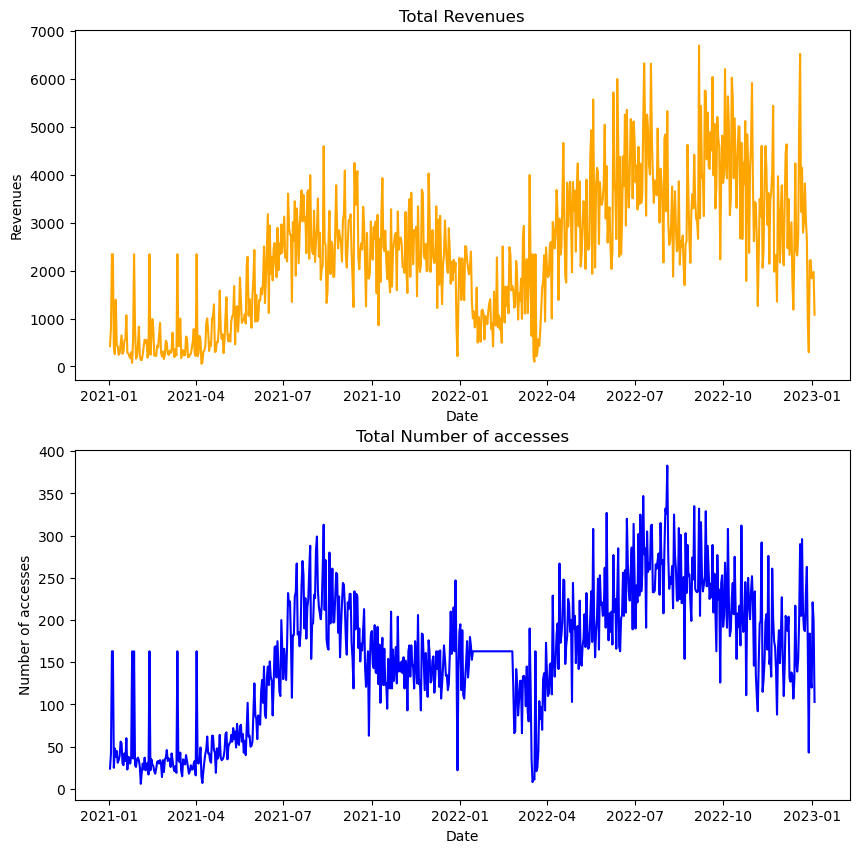

In [159]:
temp = data.copy()
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(temp['date'], temp['tot_cash'], color = 'orange')
axes[1].plot(temp['date'], temp['tot_num'], color='blue') #hole in the series for tot_num
axes[0].set_title('Total Revenues')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenues')

axes[1].set_title('Total Number of accesses')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of accesses')
plt.show()

In the following cells I split the data in a before and after the beginning of 2022 beacaUse there is a month and a half of tot_num missing. This was done to be able to carry out all the analysis on tot_num.\
The focus of this analysis is on the number of accesses, however as a diagnostic check I perform the same analysis on the revenues. In the end the results hold for both series

To better look at the trend I plot the relative number of accesses and revenues. From the graph it is clear that they both follow the same trend with and increase around July/August

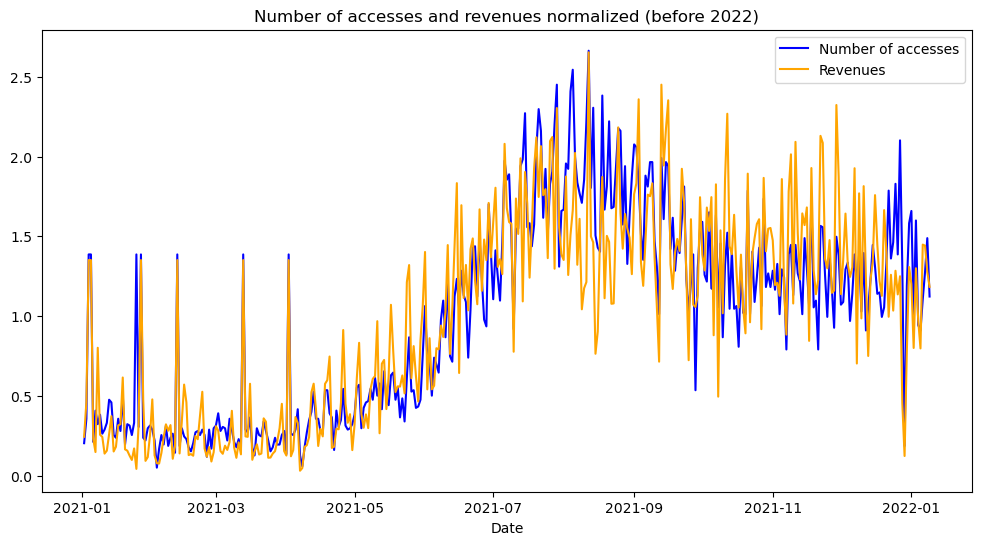

In [160]:
temp_1 = temp[temp['date']<'2022-01-10']
temp_1.set_index(temp_1['date'], inplace=True) #before streak of null values (beginnign of 2022)
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot((temp_1['tot_num']/temp_1['tot_num'].mean()), color = 'blue')
axes.plot(temp_1['tot_cash']/temp_1['tot_cash'].mean(), color ='orange')
axes.legend(['Number of accesses', 'Revenues'])
axes.set_title('Number of accesses and revenues normalized (before 2022)')
axes.set_xlabel('Date')
plt.show()

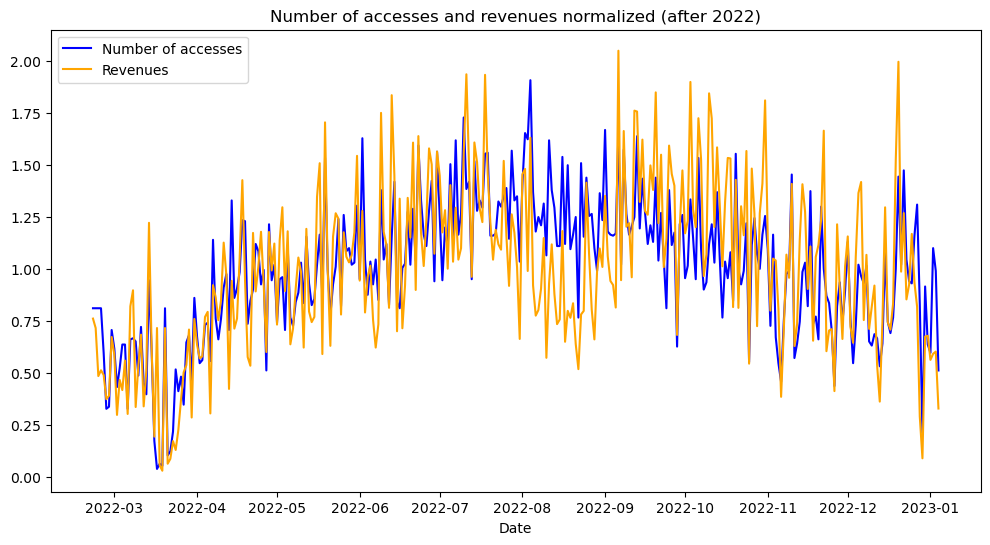

In [161]:
temp_2 = temp[temp['date']>'2022-02-20']
temp_2.set_index(temp_2['date'], inplace=True) #after streak of null values (beginning of 2022)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(temp_2['tot_num']/temp_2['tot_num'].mean(), color='blue')
axes.plot(temp_2['tot_cash']/temp_2['tot_cash'].mean(), color = 'orange')
axes.legend(['Number of accesses', 'Revenues'])
axes.set_title('Number of accesses and revenues normalized (after 2022)')
axes.set_xlabel('Date')
plt.show()

The dataset temp_conc is the series without the data from 2022-01-10 to 2022-02-20

In [162]:
temp_conc = pd.concat([temp_1,temp_2])
temp_conc['tot_cash'] = temp_conc['tot_cash'].fillna(temp_conc['tot_cash'].median())

#### Difference across day of the week

Looking at the scatter plot for different days there seems to be a difference with more people coming during the week. 
(note for the number of accesses I use the "corrected" dataset, for revenues the whole dataset)

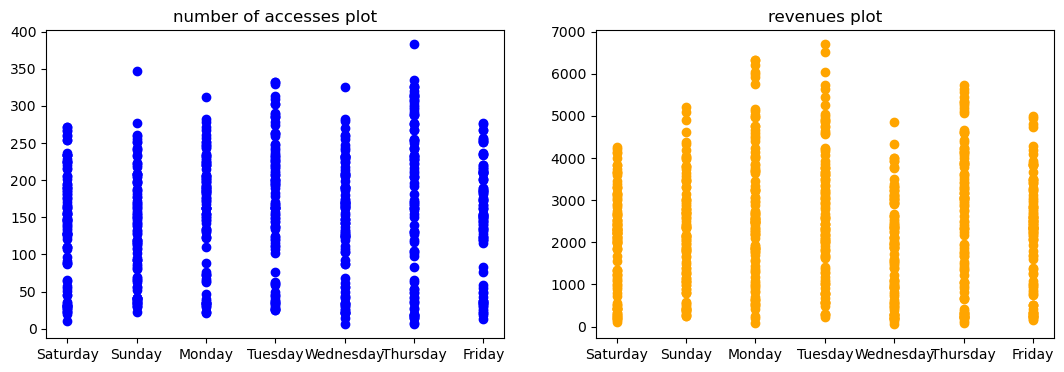

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
axes[0].scatter(temp_conc['day_of_week'], temp_conc['tot_num'], color='blue')
axes[0].set_title('number of accesses plot')

axes[1].scatter(temp['day_of_week'], temp['tot_cash'], color='orange')
axes[1].set_title('revenues plot')

plt.show()

In [164]:
weekday = temp_conc[temp_conc['day_of_week'].apply(
    lambda x: True if x in ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Wednesday', 'Friday') else False
)]
weekend = temp_conc[temp_conc['day_of_week'].apply(
    lambda x: True if x in ('Sunday', 'Saturday') else False
)]

Difference is indeed statistically significant as can be seen form the ANOVA test (low p-value)

In [165]:
grouped_data = [temp_conc.loc[temp_conc['day_of_week'] == group]['tot_num'] for group in temp_conc['day_of_week'].unique()]

f_statistic, p_valuef = f_oneway(
    grouped_data[0], grouped_data[1], grouped_data[2],grouped_data[3],grouped_data[4],grouped_data[5],grouped_data[6]
)

t_statistic, p_valuet = ttest_ind(weekday['tot_num'], weekend['tot_num'], equal_var=False)

print(f'f-test pvalue: {p_valuef}') #difference statistically significant
print(f't-test pvalue: {p_valuet}') #difference statistically significant

f-test pvalue: 0.0010895375740299614
t-test pvalue: 0.0007965613564457022


In [166]:
grouped_dict = {group: temp_conc.loc[temp_conc['day_of_week'] == group]['tot_num'].tolist() for group in temp_conc['day_of_week'].unique()}
for x in grouped_dict:
    print(x, np.mean(grouped_dict[x]))
#more people on Monday, Tuesday, Thursday

Saturday 142.9090909090909
Sunday 137.82828282828282
Monday 162.05050505050505
Tuesday 170.85858585858585
Wednesday 146.1919191919192
Thursday 180.8469387755102
Friday 151.03061224489795


For revenues we can look at te whole series since we don't have the problem of missing values at the beginning of 2022 and the difference is still very significant (low p-value in the ANOVA test)

In [167]:
grouped_data = [temp.loc[temp['day_of_week'] == group]['tot_cash'] for group in temp['day_of_week'].unique()]

f_statistic, p_valuef = f_oneway(grouped_data[0], grouped_data[1], grouped_data[2],grouped_data[3],grouped_data[4],grouped_data[5],grouped_data[6])
t_statistic, p_valuet = ttest_ind(weekday['tot_cash'], weekend['tot_cash'], equal_var=False)

print(f'f-test pvalue: {p_valuef}') #difference statistically significant
print(f't-test pvalue: {p_valuet}') #difference statistically significant

f-test pvalue: 3.75620257226098e-07
t-test pvalue: 0.0012017202881590707


In [168]:
grouped_dict = {group: temp.loc[temp['day_of_week'] == group]['tot_cash'].tolist() for group in temp['day_of_week'].unique()}
for x in grouped_dict:
    print(x, np.mean(grouped_dict[x]))
#more revenues on Monday, Tuesday, Thursday

Saturday 2055.5780952380956
Sunday 2193.1590476190477
Monday 2745.0361904761903
Tuesday 2771.3367619047617
Wednesday 1909.910476190476
Thursday 2674.3901923076924
Friday 2240.191346153846


#### Difference in weather

The second focus of this anaysis is on the weather and in particular the goal is understanding if the parking lot receives more customer when it rains. By looking at the box plot it seems that there is a difference days with and without rain, with rainy days receiving less customers than non-rainy days. \
This is somewhat unexpected since the prior belief was that when there is "bad" weather, people are more likely to take the car and therefore demand for parking spots would be higher

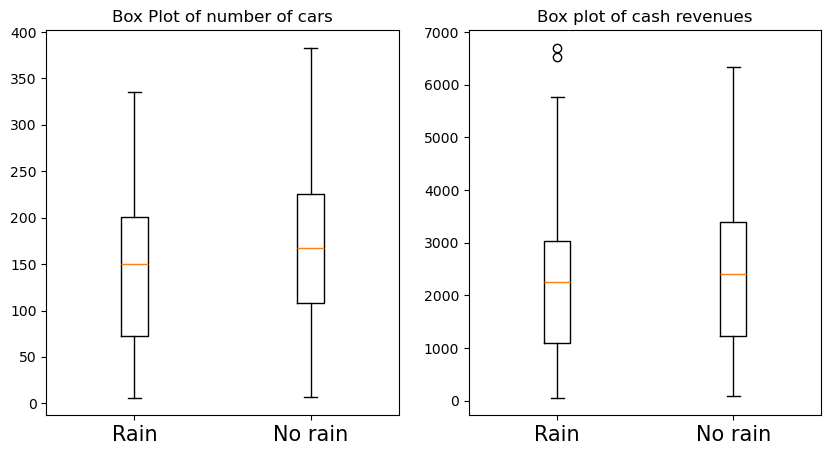

In [169]:
rain_num = temp_conc[temp_conc['rain']==1]['tot_num']
no_rain_num = temp_conc[temp_conc['rain']==0]['tot_num']

rain_cash = temp[temp['rain']==1]['tot_cash']
no_rain_cash = temp[temp['rain']==0]['tot_cash']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].boxplot([rain_num, no_rain_num])
axes[0].set_title('Box Plot of number of cars')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Rain', 'No rain'], fontsize=15)

axes[1].boxplot([rain_cash, no_rain_cash])
axes[1].set_title('Box plot of cash revenues')
axes[1].set_xticks([1, 2], ['Rain', 'No rain']) 
axes[1].set_xticklabels(['Rain', 'No rain'], fontsize=15)  

plt.show()

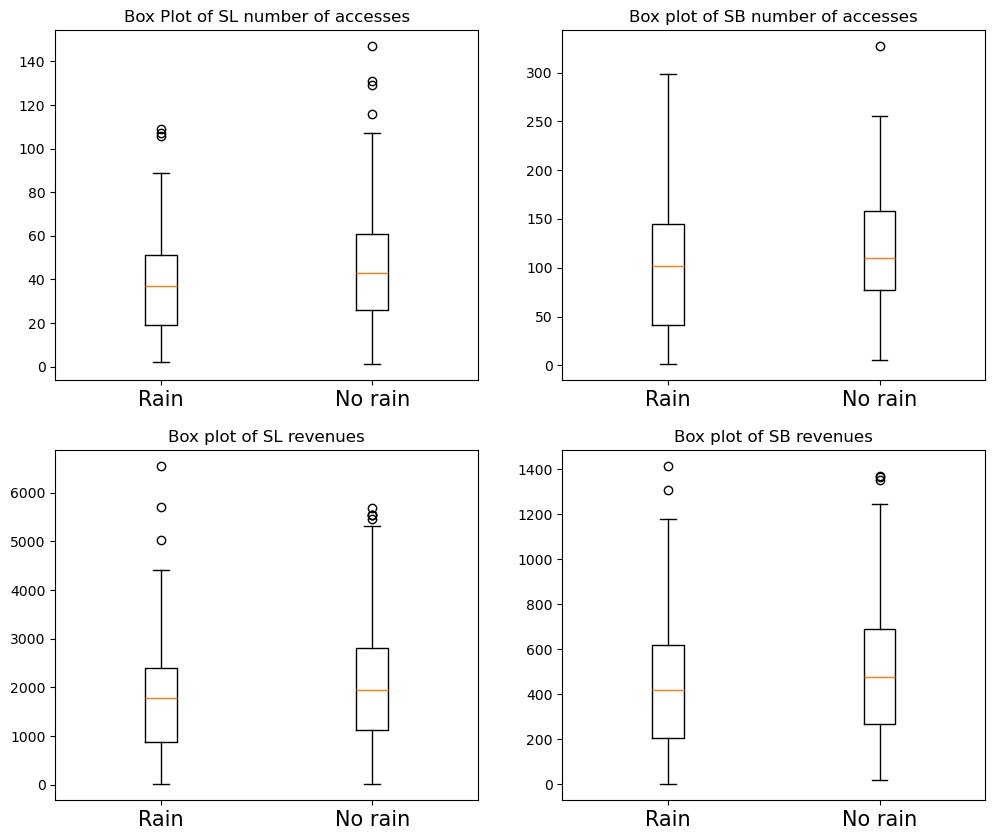

In [170]:
rain_sl_num = temp_conc[temp_conc['rain']==1]['SL_num']
no_rain_sl_num = temp_conc[temp_conc['rain']==0]['SL_num']

rain_sb_num = temp[temp['rain']==1]['SB_num']
no_rain_sb_num = temp[temp['rain']==0]['SB_num']

rain_sl_cash = temp_conc[temp_conc['rain']==1]['SL_cash']
no_rain_sl_cash = temp_conc[temp_conc['rain']==0]['SL_cash']

rain_sb_cash = temp[temp['rain']==1]['SB_cash']
no_rain_sb_cash = temp[temp['rain']==0]['SB_cash']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].boxplot([rain_sl_num, no_rain_sl_num])
axes[0,0].set_title('Box Plot of SL number of accesses')
axes[0,0].set_xticks([1, 2])
axes[0,0].set_xticklabels(['Rain', 'No rain'], fontsize=15)

axes[0,1].boxplot([rain_sb_num, no_rain_sb_num])
axes[0,1].set_title('Box plot of SB number of accesses')
axes[0,1].set_xticks([1, 2], ['Rain', 'No rain']) 
axes[0,1].set_xticklabels(['Rain', 'No rain'], fontsize=15)  

axes[1,0].boxplot([rain_sl_cash, no_rain_sl_cash])
axes[1,0].set_title('Box plot of SL revenues')
axes[1,0].set_xticks([1, 2], ['Rain', 'No rain']) 
axes[1,0].set_xticklabels(['Rain', 'No rain'], fontsize=15)  

axes[1,1].boxplot([rain_sb_cash, no_rain_sb_cash])
axes[1,1].set_title('Box plot of SB revenues')
axes[1,1].set_xticks([1, 2], ['Rain', 'No rain']) 
axes[1,1].set_xticklabels(['Rain', 'No rain'], fontsize=15)

plt.show()

It is difficult to understand exactly if there is a correlatio between rain and number of accesses/revenues by just looking at the boxplot. To understand exactly what is going on perform an ANOVA test.

In [171]:
grouped_data = [temp_conc.loc[temp_conc['rain'] == group]['tot_num'] for group in temp_conc['rain'].unique()]

f_statistic, p_value = f_oneway(grouped_data[0], grouped_data[1])
print(p_value) #statistically significant

0.010460640489979857


In [172]:
grouped_dict = {group: temp_conc.loc[temp_conc['rain'] == group]['tot_cash'].tolist() for group in temp_conc['rain'].unique()}
for x in grouped_dict:
    print(x, np.mean(grouped_dict[x]))

1 2238.3325688073396
0 2536.5246088794925


In [173]:
grouped_data = [temp.loc[temp['rain'] == group]['tot_cash'] for group in temp['rain'].unique()]

f_statistic, p_value = f_oneway(grouped_data[0], grouped_data[1])
print(p_value) #statistically significant (not strongly but stil)

0.04677531491781847


In [174]:
grouped_dict = {group: temp.loc[temp['rain'] == group]['tot_cash'].tolist() for group in temp['rain'].unique()}
for x in grouped_dict:
    print(x, np.mean(grouped_dict[x]))

1 2213.8155555555554
0 2438.750275590551


Counter-intuitively and also opposite to my prior belief, the demand for parking spots is higher when it does not rain. This difference is strongly statistically significant for the number of accesses and only weakly significant for the revenues.

#### Seasonality

To look for possible seasonal effect, I try to perform a trend-cycle decomposition of this time-series as well as perform a Kruskal-Wallis test. By just looking at the plots it seems that there is a possible quarterly effect.\
The analysis indeed shows that there are statistical evidences in favor of this idea with the p-value for the test (null is no seasonality, or better that all periods have the same mean) being very low. The test suggests that the mean is different across quarters, this however should be taken with a bit of care since the series I am observing is rather short (just two years) and display an overall upward trend.

In [175]:
temp = data.set_index(pd.to_datetime(data['date'], format='%b-%y'))
revenues = temp[['tot_cash']].copy()
number = temp[['tot_num']].copy()

In [176]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_rev = seasonal_decompose(revenues, model="multiplicative", period=6)
decompose_num = seasonal_decompose(number, model="multiplicative", period=6)

#decompose_rev.plot()

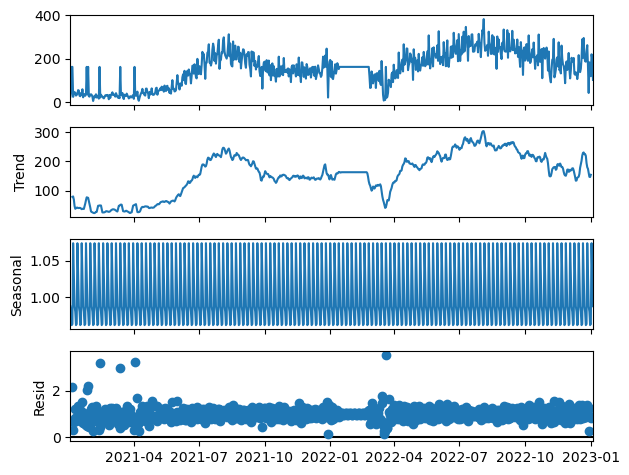

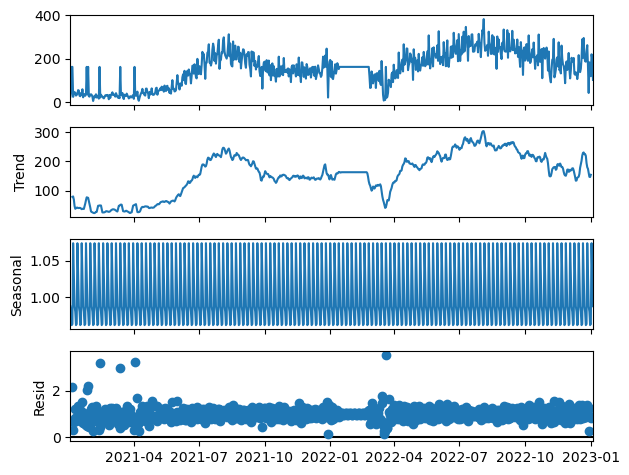

In [177]:
decompose_num.plot()

In [178]:
from scipy.stats import kruskal

res = []

for i in temp['date'].dt.quarter.unique():
    res.append(temp[temp['date'].dt.quarter == i]['tot_cash'])

result = kruskal(*res)
print(result)

KruskalResult(statistic=301.9096086248783, pvalue=3.841239724926394e-65)


In [179]:
res = []

for i in temp['date'].dt.quarter.unique():
    res.append(temp[temp['date'].dt.quarter == i]['tot_num'])

result = kruskal(*res)
print(result)

KruskalResult(statistic=302.9535405269689, pvalue=2.2831220032221343e-65)


### Summary

To sum up the main finding of this analysis are:
- there appears to be a seasonal trend, with more people clients and revenues in the months between July and September (summer season)
- demand is higher during weekdays
- demad is lower during rainy days

A possible explanation for the third point (which I find counterintuitive and is the opposite of my prior belief) is that the parking lot is located outside, so even if there may be more people taking the car, this additional demand may be directed to covered parking spaces